# Домашняя работа часть 1  (20 баллов): анализ падения точности LLM после квантизации и спарсификации


В этом задании вам предстоит проанализировать популярные методы компресии больших языковых моделей, среди которых QUIK, Wanda и SparseGPT, комбинация SparseGPT и GPTQ

В качестве языковой модели будет использована модель opt-350m.

Результат задания: Построить 8 графиков (по одному для каждого из 4 методов компресии и двух тестовых датасетов) зависимости точности модели от уровня сжатия в 0, 2 и 4 раза.

В виде решения нужно будет сдать ноутбук с построенными графиками и выводами, в частности ответить на вопрос какой метод компрессии выбрать для сохранения наилучшего качества.


## Подготовка окружения

In [1]:
!pip install -U -q datasets accelerate lm-eval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.3/336.3 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 9.3 MB/s eta 0:00

In [2]:
!mkdir spars_quant

In [3]:
%cd ./spars_quant

/content/spars_quant


In [4]:
!git init
!git remote add -f origin https://github.com/On-Point-RND/Efficient-DL-models-Seminars.git
!git config core.sparseCheckout true
!echo "Home Work/HW 1" >> .git/info/sparse-checkout
!git pull origin master

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/spars_quant/.git/
Updating origin
remote: Enumerating objects: 498, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 498 (delta 51), reused 167 (delta 44), pack-reused 310 (from 1)
Receiving objects: 100% (498/498), 518.78 MiB | 17.37 MiB/s, done.
Resolving deltas: 100% (126/126), done.
From https://github.com/On-Point-RND/Efficient-DL-models-Seminars
 * [new branch]      master     -> origin/mast

In [10]:
%cd /content

/content


In [6]:
import os
SAVING_DIR = '/content/'
os.environ["TRANSFORMERS_CACHE"] = SAVING_DIR + "hf_cache/"
os.environ["HF_HOME"] = SAVING_DIR + "hf_cache/"

## Загрузка модели

https://huggingface.co/facebook/opt-350m <br>

OPT: Open Pre-trained Transformer Language Models <br>
Семейство моделей с архитектурой GPT-трансформера, выпущенные в начале 2022 года. Обучение моделей выполнялось на корпусах, состоящих преимущественно из текстов на английском языке.

In [7]:
!git clone https://huggingface.co/facebook/opt-350m

Cloning into 'opt-350m'...
remote: Enumerating objects: 115, done.
remote: Total 115 (delta 0), reused 0 (delta 0), pack-reused 115 (from 1)
Receiving objects: 100% (115/115), 558.77 KiB | 1.19 MiB/s, done.
Resolving deltas: 100% (59/59), done.
Filtering content: 100% (3/3), 1.85 GiB | 42.71 MiB/s, done.


## lm-evaluation-harness <br>

https://github.com/EleutherAI/lm-evaluation-harness/ <br>

harness - единый фреймворк для тестирования эффективности языковых модели на большом количестве различных заданий. <br>

https://huggingface.co/datasets/winogrande <br>

WinoGrande - коллекция из 44 тыс. вопросов, вдохновленная Winograd Schema Challenge (Левеск, Дэвис и Моргенштерн, 2011). Каждый вопрос формулируется в виде тестового задания с двумя ответами. Цель выбрать правильный ответ, что требует рассуждений на основе здравого смысла.

<img src="https://github.com/iptkachev/Efficient-DL-Models/blob/master/Home%20Work/HW%201/notebooks/images/winogrande.png?raw=1">

https://huggingface.co/datasets/google/boolq

BoolQ - набор из 15942 заданий с ответами "да"/"нет" на вопросы, которые формулируются на основе отрывка текста.

<img  src="https://github.com/iptkachev/Efficient-DL-Models/blob/master/Home%20Work/HW%201/notebooks/images/boolq.png?raw=1">

In [ ]:
!lm_eval --model hf \
--model_args "pretrained=/content/opt-350m" \
--tasks winogrande,boolq \
--batch_size 4 \
--num_fewshot 0 \
--device cuda \
--trust_remote_code

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2024-12-01 16:53:00.539492: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-01 16:53:00.558700: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-01 16:53:00.564529: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 16:53:00.578302: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in p

## Метод квантизации QUIK <br>

https://github.com/IST-DASLab/QUIK/tree/master <br>
https://arxiv.org/pdf/2310.09259.pdf <br>

<img src="https://github.com/iptkachev/Efficient-DL-Models/blob/master/Home%20Work/HW%201/notebooks/images/quik.png?raw=1">

Метод GPTQ выполняет послойную квантизацию модели с компенсацией ошибки квантизации путем обновления еще не квантизованных весов. <br>
Для каждого линейного слоя матрица весов $\mathbf{W}$ квантизуется последовательно по столбцам, при этом еще не квантизованные веса обновляются, чтобы компенсировать возникшую ошибку:

$\begin{equation}
\mathbf{W}_{update} = \mathbf{W} + \delta \mathbf{W} = \mathbf{W} + \dfrac{(\tilde{\mathbf{W}}_{m} - \mathbf{W}_{m})}{[\mathbf{H}^{-1}]_{mm}} \mathbf{H}^{-1}_{:, m}, \quad \mathbf{H} = \mathbf{X}\mathbf{X}^{T}
\end{equation}$

где $m$ - индекс столбца, который квантизуется, $\mathbf{X}$ - матрица активаций, $\tilde{\mathbf{W}}$ - деквантизованные веса. <br>
Для того чтобы ускорить процесс квантизации и не обновлять всю матрицу $\mathbf{W}$ после квантизации каждого столбца, они объединяются в блоки (стандартный размер 128). При таком подходе, неквантизованные веса обновляются только в рамках одного блока.

Метод QUIK - улучшение версия метода GPTQ, в котором в матрицах весов $W$ каждого слоя модели выделяются столбцы outliers. Данные столбцы не квантизуются, что дает возможность существенно повысить качество модели
без значительного увеличения в ее размере. В отличии от LLM.int8() столбцы outliers определяются заранее, исходя из максимального значения активаций в каждом слое, расчитанных на калибровочном датасете. Благодаря этому метод QUIK имеет более высокую скорость инференса по сравнению с LLM.int8().


Выбор чувствительных к квантизации столбцов в QUIK выбирается, исходя значения активаций $\mathbf{X}$, посчитанных на калибровочном датасете:

$
\mathbf{i} =  \underset{\mathbf{i}}{argmax}\mathbf{X}, \\ $
где $\mathbf{i}$ - 128 индексов столбцов, которые не квантизуются и остаются в fp16.

Более подробно про методы квантизации GPTQ и LLM.int8() будет рассказано в лекции про оптимизацию LLM.

<em> Описание параметров: </em>

`model` - путь к директории, где хранится модель. <br>
`path_to_act_scales` - путь к файлу с максимальными значений активаций для каждого слоя. <br>
Данный файл может быть получен с помощью `generate_act_scales.py` из репозитория `https://github.com/mit-han-lab/smoothquant/tree/main`. <br>
`path_to_save_quant_model` - путь к директории, где будет сохранена модель после квантизации. Модель сохранятся с деквантизованными fp весами. <br>
`fp_features` - количество столбцов outliers в каждом слое, которые не будут квантизованы. <br>
`a_bits` - уровень битности [4, 8, 16], в котором будут вычислены активации для каждого слоя. Если уровень битности меньше 16, то активации квантизуются. Но активации, соответствующие столбцам outliers, остаются всегда в fp16/bf16. <br>
`w_bits` - уровень квантизации [4, 8, 16] весов модели. сли уровень битности 16, то веса не квантизуются. <br>
`w_clip` - индикатор, указывающий, что коэффициент $\alpha$, который используется для масштабирования весов модели $\dfrac{\mathrm{abs}(\mathbf{W})}{\alpha}$ при квантизации, будет найден путем подбора, исходя из минимизации ошибки квантизации $ \lVert \mathbf{W} - \tilde{\mathbf{W}} \rVert_{2}$, где $\tilde{\mathbf{W}}$ - деквантизованные веса. Поскольку в этом случае значение $\alpha$ может быть меньше, чем максимальное значение весов $\mathbf{W}$, то веса модели после квантизации $(2^{\mathrm{w\_bits} - 1} - 1)\dfrac{\mathbf{W}}{\alpha}$ ограничиваются до промежутка $[-2^{\mathrm{w\_bits} - 1},\, 2^{\mathrm{w\_bits} - 1} - 1]$. <br>
`dataset` - калиброчовный датасет, который используется для вычисления матрицы Гессе $\mathbf{H}$ для каждого слоя модели.



In [17]:
!python /content/spars_quant/Home\ Work/HW\ 1/quik/experiments/fake_quant/opt.py \
    --model /content/opt-350m \
    --path_to_act_scales /content/spars_quant/Home\ Work/HW\ 1/quik/experiments/act_scales/opt_350m.pt \
    --path_to_save_quant_model /content/weight/opt_350_w8_a16 \
    --fp_features 128 \
    --a_bits 16 \
    --w_bits 8 \
    --w_clip \
    --dataset wikitext2 &> /dev/null

!lm_eval --model hf \
    --model_args "pretrained=/content/weight/opt_350_w8_a16" \
    --tasks winogrande,boolq \
    --batch_size 4 \
    --num_fewshot 0 \
    --device cuda \
    --trust_remote_code

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2024-12-08 11:37:18.638658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-08 11:37:18.658303: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-08 11:37:18.664916: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 11:37:18.679036: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in p

In [ ]:
!python /content/spars_quant/Home\ Work/HW\ 1/quik/experiments/fake_quant/opt.py \
    --model /content/opt-350m \
    --path_to_act_scales /content/spars_quant/Home\ Work/HW\ 1/quik/experiments/act_scales/opt_350m.pt \
    --path_to_save_quant_model /content/weight/opt_350_w4_a16 \
    --fp_features 128 \
    --a_bits 16 \
    --w_bits 4 \
    --w_clip \
    --dataset wikitext2 &> /dev/null

!lm_eval --model hf \
    --model_args "pretrained=/content/weight/opt_350_w4_a16" \
    --tasks winogrande,boolq \
    --batch_size 4 \
    --num_fewshot 0 \
    --device cuda \
    --trust_remote_code

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2024-12-01 17:15:42.850868: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-01 17:15:42.870401: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-01 17:15:42.876271: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 17:15:42.890628: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in p

## Метод спарсификации SparseGPT

https://github.com/IST-DASLab/sparsegpt

SparseGPT - метод спарсификации LLM, основанные на процедуре Optimal Brain Surgeon (OBS). Оценка значимости каждого веса $w_{m}$ в матрице весов $\mathbf{W}$ выполняется, исходя из его влияния на функцию Лагранжа:

\begin{equation}
L = \dfrac{1}{2} \dfrac{w_{m}^{2}}{[\mathbf{H}^{-1}]_{mm}}.
\end{equation}

Согласно теории OBS функция Лагранжа $L$ связана с ошибкой $E$, вызванной занулением веса $w_{m}$:

$\begin{equation}
E = \lVert \mathbf{W}\mathbf{X} - \tilde{\mathbf{W}}\mathbf{X} \rVert_{2}^{2},
\end{equation}$
где $\tilde{\mathbf{W}}$ - матрица весов после зануления $w_{m}$.

После расчета значимости каждого веса в выбранном слое, выполняется последовательное (слево-направо) обнуления малозначимых весов $w_{m}$. По аналогии с GPTQ обнуление весов выполняется по столбцам, которые сгруппированы в блоки.
При этом ошибка, вызыванная спарсификацией, компенсируется путем калибровки весов, находящихся в одной строке с зануленными весами $\mathbf{w}_{m}$:

$\begin{align}
\mathbf{w}_{update} = \mathbf{w} + \delta \mathbf{w} = \mathbf{w} + \dfrac{\mathbf{w}_{m}}{[\mathbf{H}^{-1}]_{mm}} \mathbf{H}^{-1}_{:, m}
\end{align}$

<em> Описание параметров </em>
`model` - путь к директории, где хранится модель. <br>
`dataset` - калибровочный датасет, который используется для расчета матрицы Гессе $\mathbf{H}$. <br>
`sparsity` - коэффициент спарсификации, в интервале от 0.0 (оригинальная модель) до 1.0.<br>
`wbits` - уровень битности для спарсифированной модели [4, 8, 16]. Если уровень битности меньше 16, то
вместе со спарсификацией будет выполнена также квантизация модели методом GPTQ. Если уровень спрасификации 0.0, то будет выполнена только квантизация методом GPTQ. <br>
`sparsity_type` - тип спарсификации. <br>
`save_model` - путь к директории, в которой будет сохранена модель.

In [ ]:
!python  /content/spars_quant/Home\ Work/HW\ 1/sparsegpt/opt.py \
    --model /content/opt-350m \
    --dataset wikitext2 \
    --sparsity 0.5 \
    --wbits 16 \
    --save /content/weight/opt350m_sparsegpt_50_w16_a16 &> /dev/null

!lm_eval --model hf \
    --model_args "pretrained=/content/weight/opt350m_sparsegpt_50_w16_a16" \
    --tasks winogrande,boolq \
    --batch_size 4 \
    --num_fewshot 0 \
    --device cuda \
    --trust_remote_code

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2024-12-01 17:29:20.638180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-01 17:29:20.658929: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-01 17:29:20.664904: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 17:29:20.678950: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in p

In [21]:
!python  /content/spars_quant/Home\ Work/HW\ 1/sparsegpt/opt.py \
    --model /content/opt-350m \
    --dataset wikitext2 \
    --sparsity 0.75 \
    --wbits 16 \
    --save /content/weight/opt350m_sparsegpt_75_w16_a16 &> /dev/null

!lm_eval --model hf \
    --model_args "pretrained=/content/weight/opt350m_sparsegpt_75_w16_a16" \
    --tasks winogrande,boolq \
    --batch_size 4 \
    --num_fewshot 0 \
    --device cuda \
    --trust_remote_code

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2024-12-08 12:25:50.352371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-08 12:25:50.372747: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-08 12:25:50.378610: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 12:25:50.393710: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in p

Пример запуска скрипта для квантизации модели методом GPTQ до уровня 4 бит (wbits = 4). <br>
Для того чтобы одновременно выполнить квантизацию и спарсификацию, необходимо указать коэффициент
спарсификации (напр. sparsity = 50%)

In [19]:
!python  /content/spars_quant/Home\ Work/HW\ 1/sparsegpt/opt.py \
    --model /content/opt-350m \
    --dataset wikitext2 \
    --sparsity 0.0 \
    --wbits 8 \
    --save /content/weights/opt350m_gptq_w8_a16 &> /dev/null

!lm_eval --model hf \
    --model_args "pretrained=/content/weights/opt350m_gptq_w8_a16" \
    --tasks winogrande,boolq \
    --batch_size 4 \
    --num_fewshot 0 \
    --device cuda \
    --trust_remote_code

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2024-12-08 11:59:46.433216: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-08 11:59:46.465469: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-08 11:59:46.476176: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 11:59:46.503633: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in p

In [ ]:
!python  /content/spars_quant/Home\ Work/HW\ 1/sparsegpt/opt.py \
    --model /content/opt-350m \
    --dataset wikitext2 \
    --sparsity 0.0 \
    --wbits 4 \
    --save /content/weights/opt350m_gptq_w4_a16 &> /dev/null

!lm_eval --model hf \
    --model_args "pretrained=/content/weights/opt350m_gptq_w4_a16" \
    --tasks winogrande,boolq \
    --batch_size 4 \
    --num_fewshot 0 \
    --device cuda

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2024-12-01 17:42:50.256104: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-01 17:42:50.275837: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-01 17:42:50.281819: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 17:42:50.296172: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in p

## Метод спарсификации Wanda

https://github.com/locuslab/wanda?tab=readme-ov-file

Wanda - метод неструктурной спарсификации LLM, в котором ранжирование значимости весов $\mathbf{W}$ каждого слоя модели выполняется посредством метрики:

$\begin{align}
score(\mathbf{W}) = \lvert \mathbf{W} \rvert \cdot \lVert \mathbf{X} \rVert_{2},
\end{align}$
где $\lVert \mathbf{X} \rVert_{2}$ - усредненные по всем строкам посредством $L_{2}$ нормы значения активаций.

<img src="https://github.com/iptkachev/Efficient-DL-Models/blob/master/Home%20Work/HW%201/notebooks/images/wanda.png?raw=1">

<em> Описание параметров </em>
`model` - путь к директории, где хранится модель. <br>
`prune_method` - метод спарсификации. <br>
`sparsity_ratio` - коэффициент спарсификации, в интервале от 0.0 (оригинальная модель) до 1.0. <br>
`sparsity_type` - тип спарсификации. <br>
`save_model` - путь к директории, в которой будет сохранена модель.

In [ ]:
!python /content/spars_quant/Home\ Work/HW\ 1/wanda/main_opt.py \
    --model /content/opt-350m \
    --prune_method wanda \
    --sparsity_ratio 0.5 \
    --sparsity_type unstructured \
    --save_model /content/weight/opt350m_wanda_50 &> /dev/null

!lm_eval --model hf \
    --model_args "pretrained=/content/weight/opt350m_wanda_50" \
    --tasks winogrande,boolq \
    --batch_size 4 \
    --num_fewshot 0 \
    --device cuda \
    --trust_remote_code

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2024-12-01 17:53:28.185422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-01 17:53:28.218591: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-01 17:53:28.228906: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 17:53:28.253108: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in p

In [22]:
!python /content/spars_quant/Home\ Work/HW\ 1/wanda/main_opt.py \
    --model /content/opt-350m \
    --prune_method wanda \
    --sparsity_ratio 0.75 \
    --sparsity_type unstructured \
    --save_model /content/weight/opt350m_wanda_75 &> /dev/null

!lm_eval --model hf \
    --model_args "pretrained=/content/weight/opt350m_wanda_75" \
    --tasks winogrande,boolq \
    --batch_size 4 \
    --num_fewshot 0 \
    --device cuda \
    --trust_remote_code

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2024-12-08 12:36:37.353388: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-08 12:36:37.373175: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-08 12:36:37.379289: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 12:36:37.394458: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in p

# Ваши графики и решения тут:

In [1]:
import pandas as pd
import io
import matplotlib.pyplot as plt
import seaborn as sns

def parse_text_table(table_text: str):
  df = pd.read_csv(io.StringIO(table_text), sep='|', skiprows=[1], skipinitialspace=True)
  df = df.drop(df.columns[[0, 2, 3, 4, 5, 6, 8, 10]], axis=1)
  df.columns = [col.strip() for col in df.columns]
  df['Tasks'] = df['Tasks'].str.strip()
  df['Value'] = df['Value'].astype(float)
  df['Stderr'] = df['Stderr'].astype(float)
  return df

In [2]:
analysis_data = {
    "baseline": """|  Tasks   |Version|Filter|n-shot|Metric|   |Value |   |Stderr|
|----------|------:|------|-----:|------|---|-----:|---|-----:|
|boolq     |      2|none  |     0|acc   |↑  |0.5771|±  |0.0086|
|winogrande|      1|none  |     0|acc   |↑  |0.5225|±  |0.0140|""",

    "quik_w8_a16": """|  Tasks   |Version|Filter|n-shot|Metric|   |Value |   |Stderr|
|----------|------:|------|-----:|------|---|-----:|---|-----:|
|boolq     |      2|none  |     0|acc   |↑  |0.5768|±  |0.0086|
|winogrande|      1|none  |     0|acc   |↑  |0.5201|±  |0.0140|""",
    "quik_w4_a16": """|  Tasks   |Version|Filter|n-shot|Metric|   |Value |   |Stderr|
|----------|------:|------|-----:|------|---|-----:|---|-----:|
|boolq     |      2|none  |     0|acc   |↑  |0.5651|±  |0.0087|
|winogrande|      1|none  |     0|acc   |↑  |0.5296|±  |0.0140|""",

    "sparsegpt_50_w16_a16": """|  Tasks   |Version|Filter|n-shot|Metric|   |Value |   |Stderr|
|----------|------:|------|-----:|------|---|-----:|---|-----:|
|boolq     |      2|none  |     0|acc   |↑  |0.5933|±  |0.0086|
|winogrande|      1|none  |     0|acc   |↑  |0.5122|±  |0.0140|""",
     "sparsegpt_75_w16_a16": """|  Tasks   |Version|Filter|n-shot|Metric|   |Value |   |Stderr|
|----------|------:|------|-----:|------|---|-----:|---|-----:|
|boolq     |      2|none  |     0|acc   |↑  |0.3792|±  |0.0085|
|winogrande|      1|none  |     0|acc   |↑  |0.5217|±  |0.0140|""",

    "gptq_w8_a16": """|  Tasks   |Version|Filter|n-shot|Metric|   |Value |   |Stderr|
|----------|------:|------|-----:|------|---|-----:|---|-----:|
|boolq     |      2|none  |     0|acc   |↑  |0.5758|±  |0.0086|
|winogrande|      1|none  |     0|acc   |↑  |0.5249|±  |0.0140|""",
    "gptq_w4_a16": """|  Tasks   |Version|Filter|n-shot|Metric|   |Value |   |Stderr|
|----------|------:|------|-----:|------|---|-----:|---|-----:|
|boolq     |      2|none  |     0|acc   |↑  |0.5920|±  |0.0086|
|winogrande|      1|none  |     0|acc   |↑  |0.5185|±  |0.0140|""",

    "wanda_50": """|  Tasks   |Version|Filter|n-shot|Metric|   |Value |   |Stderr|
|----------|------:|------|-----:|------|---|-----:|---|-----:|
|boolq     |      2|none  |     0|acc   |↑  |0.4933|±  |0.0087|
|winogrande|      1|none  |     0|acc   |↑  |0.5004|±  |0.0141|""",
    "wanda_75": """|  Tasks   |Version|Filter|n-shot|Metric|   |Value |   |Stderr|
|----------|------:|------|-----:|------|---|-----:|---|-----:|
|boolq     |      2|none  |     0|acc   |↑  |0.5446|±  |0.0087|
|winogrande|      1|none  |     0|acc   |↑  |0.5083|±  |0.0141|""",

}

In [3]:
union_table = []
for model, text_df in analysis_data.items():
  parsed_df = parse_text_table(text_df)
  parsed_df["model"] = model
  union_table.append(parsed_df)

union_table = pd.concat(union_table, axis=0)
union_table['model_type'] = union_table['model'].apply(lambda x: x.split("_")[0])

График качества в зависимости от типа датасета. Внутри каждого подграфика цвет показывает тип квантизации, а порядок баров показывает степень сжатия этим методом в 2 и 4 раза соответственно

<ipython-input-10-d9fcb7442e42>:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right');
<ipython-input-10-d9fcb7442e42>:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right');


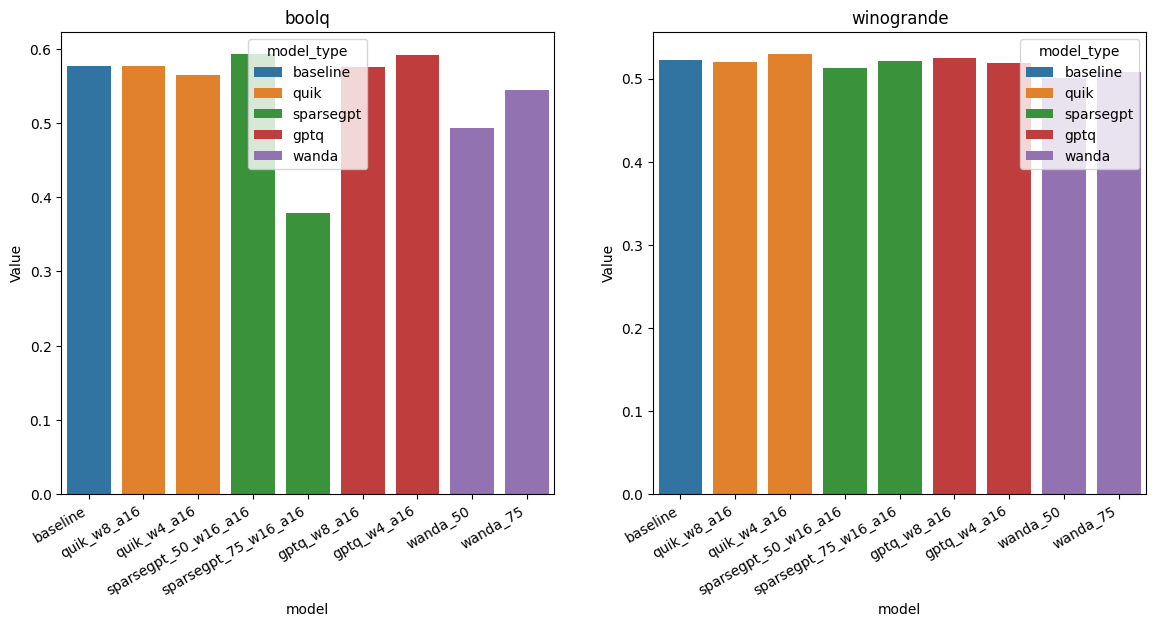

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(x="model", y="Value", data=union_table[union_table.Tasks == 'boolq'], hue="model_type", ax=axes[0])
sns.barplot(x="model", y="Value", data=union_table[union_table.Tasks == 'winogrande'], hue="model_type", ax=axes[1])
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right');

axes[0].set_title('boolq')
axes[1].set_title('winogrande')

График, показывающий усредненное качество по 2 датасетам на каждый вариант сжатия и степень сжатия 2, 4 раз

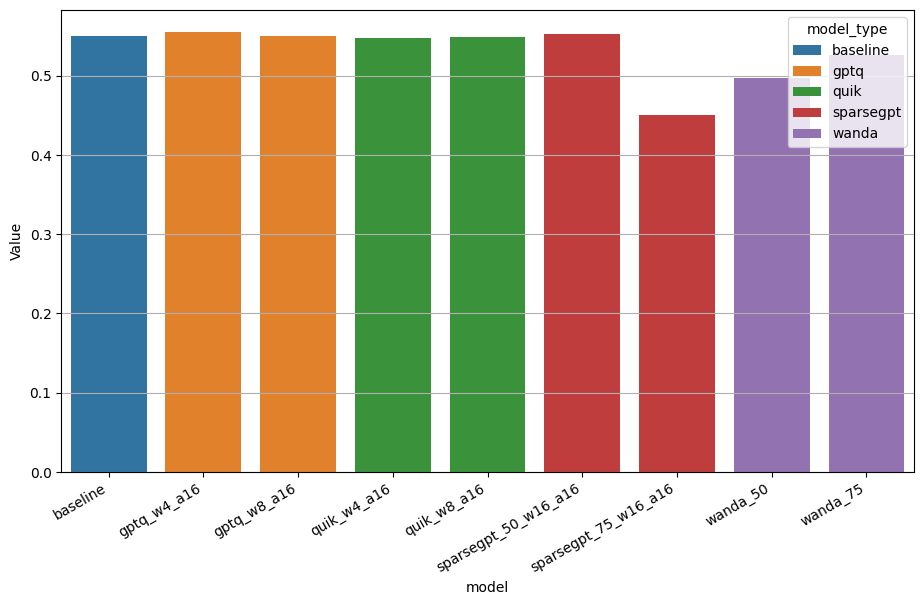

In [20]:
plt.figure(figsize=(11, 6))
avg_acc = union_table.groupby(["model", "model_type"], as_index=False)["Value"].mean()
plt.grid()
sns.barplot(x="model", y="Value", data=avg_acc, hue="model_type")
plt.xticks(rotation=30, ha='right');

Представление графика выше в логарифмической шкале, чтобы лучше увидеть разницу

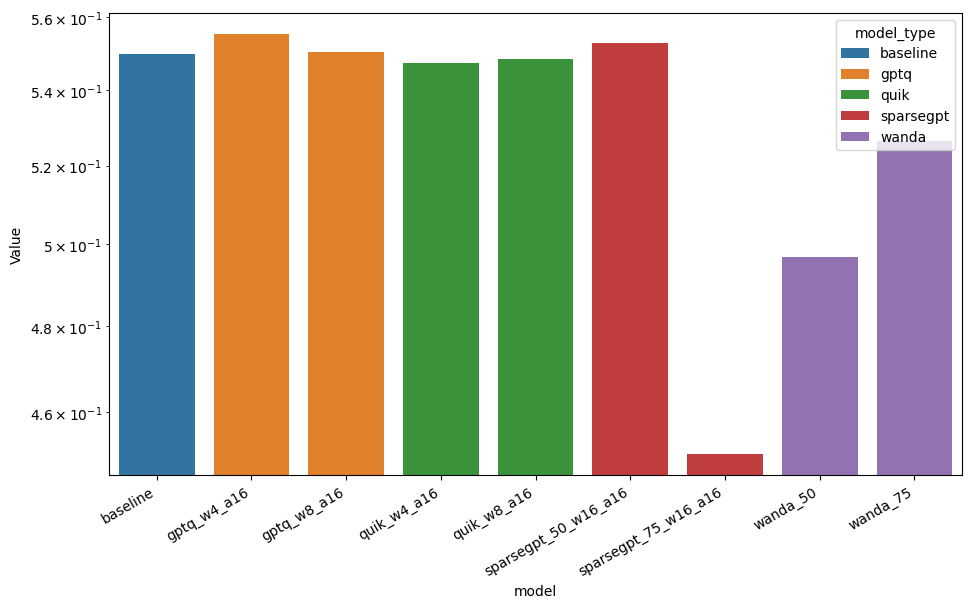

In [17]:
plt.figure(figsize=(11, 6))
avg_acc = union_table.groupby(["model", "model_type"], as_index=False)["Value"].mean()
plt.grid()
sns.barplot(x="model", y="Value", data=avg_acc, hue="model_type")
plt.yscale("log")
plt.xticks(rotation=30, ha='right');

Табличное представление графика выше (без логарифмов)

In [19]:
avg_acc.drop(columns=['model_type'])

,model,Value
0,baseline,0.54980
1,gptq_w4_a16,0.55525
2,gptq_w8_a16,0.55035
3,quik_w4_a16,0.54735
4,quik_w8_a16,0.54845
5,sparsegpt_50_w16_a16,0.55275
6,sparsegpt_75_w16_a16,0.45045
7,wanda_50,0.49685
8,wanda_75,0.52645


# Вывод по результатам анализа:
- самый неэффективный способ сжатия - это sparsegpt, потому что в случае сжатия в 4 раза (`sparsegpt_75_w16_a16`) качество драматически падает на `boolq` задаче, хотя при сжатии в 2 раза `sparsegpt_50_w16_a16` эффект не такой заметный. Также довольно плохо работает метод `wanda` по сравнению с другими способами, качество падает как при сжатии в 2 раза (`wanda_50`), так и в 4 раза (`wanda_75`). В целом это говорит о том, что спарсификация довольно заметно просаживает качество по сравнению с квантизацией
- самый эффективный вариант сжатия - это `gptq`. При сжатие как в 2 (`gptq_w4_a16`), так и в 4 (`gptq_w8_a16`) раза качество остается самым высоким на обоих вариантов заданий, более того оно растет по сравнению с `baseline` вариантом LLM, квантизация в данной конфигурации работает как регуляризация для языковой модели. Другой вариант квантизации `quik` принципиально не хуже `gptq` и сравним по качеству в целом.

Т.о. самый эффективный вариант сжатия при сохранении (или даже улучшении) качества - квантизация